# Does size of decision thresholds mediate the RUV difference between decision types?

## Logistic damages at 90th percentile threshold, risk neutral, 14-day moving average reference

In [1]:
# Copyright 2023 Richard Laugesen

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import sys
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
import pickle
import bz2

from scipy.special import xlogy

sys.path.append('..')

from ruv.relative_utility_value import *
from ruv.damage_functions import *
from ruv.economic_models import *
from ruv.utility_functions import *
from ruv.helpers import *

In [3]:
awrc = '405219'
dataset_filepath = '%s_data.pickle.bz2' % awrc
parallel_nodes = 7
verbose = False

In [4]:
with bz2.BZ2File(dataset_filepath, 'r') as f:
    data = pickle.load(f)
obs, clim_ens, fcst_ens = data['obs'], data['clim'], data['fcst']
print(obs.shape, fcst_ens.shape, clim_ens.shape)

(1932,) (1932, 100) (1932, 497)


# Define decision context

In [5]:
ref = clim_ens

alphas = np.array([0.01, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.99])

decision_definition = {
    'econ_pars': alphas,
    'damage_function': [logistic_zero, {'A': 1, 'k': 0.5, 'threshold': np.nanquantile(obs, 0.8)}],
    'economic_model': [cost_loss, cost_loss_analytical_spend],
    'decision_method': 'critical_probability_threshold_equals_par',
    'utility_function': [cara, {'A': 0}]
}

# Defining these outside the decision_definition dictionary allows 
# us to vary them as experimental variables later
decision_types = ['Binary', 'Multicategorical', 'Continuous']
max_thresholds = [0.25, 0.5, 0.75, 0.9, 0.99]

# Calculate RUV for each alpha, decision type and max_threshold

## Adjust decision threshold for binary and multicategorical decision types according to the max_threshold value

In [6]:
results = xr.DataArray(np.nan, dims=['alphas', 'decision_types', 'max_thresholds'], coords={'alphas': alphas, 'decision_types': decision_types, 'max_thresholds': max_thresholds})

for max_threshold in max_thresholds:
    binary_thresholds = np.insert(np.nanquantile(obs, [max_threshold]), 0, 0)
    multicategorical_thresholds = np.insert(np.nanquantile(obs, max_threshold - np.array([0.20, 0.15, 0.10, 0.05, 0])), 0, 0)
    
    for decision_type in decision_types:
        print(max_threshold, decision_type)
    
        if decision_type == 'Binary':
            decision_definition['decision_thresholds'] = binary_thresholds
    
        elif decision_type == 'Multicategorical':
            decision_definition['decision_thresholds'] = multicategorical_thresholds
    
        elif decision_type == 'Continuous':
            decision_definition['decision_thresholds'] = None
    
        result = relative_utility_value(obs, fcst_ens, ref, decision_definition, parallel_nodes, verbose)
        results.loc[:, decision_type, max_threshold] = result['ruv']

0.25 Binary
0.25 Multicategorical
0.25 Continuous
0.5 Binary
0.5 Multicategorical
0.5 Continuous
0.75 Binary
0.75 Multicategorical
0.75 Continuous
0.9 Binary
0.9 Multicategorical
0.9 Continuous
0.99 Binary
0.99 Multicategorical
0.99 Continuous


In [7]:
results

<xarray.DataArray (alphas: 9, decision_types: 3, max_thresholds: 5)> Size: 1kB
array([[[-3.33333333e-01,  4.65618861e-01,  6.04021655e-01,
          5.42111507e-01,  6.10499577e-01],
        [-1.54576022e-04, -2.36862179e-01,  6.53400164e-01,
          7.11285044e-01,  4.05808887e-01],
        [ 5.30696460e-01,  5.30696460e-01,  5.30696460e-01,
          5.30696460e-01,  5.30696460e-01]],

       [[ 4.23480084e-01,  7.75647172e-01,  5.78249337e-01,
          6.39431616e-01,  5.16666667e-01],
        [ 2.56074436e-01,  5.30267404e-01,  6.83538207e-01,
          6.38106726e-01,  5.38823684e-01],
        [ 6.59580280e-01,  6.59580280e-01,  6.59580280e-01,
          6.59580280e-01,  6.59580280e-01]],

       [[ 6.98145025e-01,  7.30606488e-01,  6.34765625e-01,
          7.57377049e-01,  2.87500000e-01],
        [ 4.13688437e-01,  7.26252566e-01,  6.88257367e-01,
          6.64451325e-01,  6.34384890e-01],
        [ 6.78677729e-01,  6.78677729e-01,  6.78677729e-01,
          6.78677729e-01,  6.78677729e-01]],
...
       [[ 8.12709030e-01,  7.35905045e-01,  6.83438155e-01,
          4.08376963e-01, -7.00000000e-01],
        [ 7.52527013e-01,  7.58745439e-01,  7.82096516e-01,
          6.99831858e-01,  5.35348862e-01],
        [ 6.17632989e-01,  6.17632989e-01,  6.17632989e-01,
          6.17632989e-01,  6.17632989e-01]],

       [[ 7.29569094e-01,  7.66514806e-01,  6.33123690e-01,
          3.61256545e-01, -1.60000000e+00],
        [ 6.78175486e-01,  6.94442836e-01,  7.73834551e-01,
          5.75300422e-01,  3.98249915e-01],
        [ 5.57738871e-01,  5.57738871e-01,  5.57738871e-01,
          5.57738871e-01,  5.57738871e-01]],

       [[ 8.69991823e-01,  7.10135970e-01,  4.59119497e-01,
          2.87958115e-01, -4.75000000e+00],
        [ 7.82144501e-01,  8.74560868e-01,  7.53814976e-01,
          3.92632326e-01,  2.17386043e-01],
        [ 4.99515174e-01,  4.99515174e-01,  4.99515174e-01,
          4.99515174e-01,  4.99515174e-01]]])
Coordinates:
  * alphas          (alphas) float64 72B 0.01 0.1 0.2 0.25 0.5 0.75 0.8 0.9 0.99
  * decision_types  (decision_types) <U16 192B 'Binary' ... 'Continuous'
  * max_thresholds  (max_thresholds) float64 40B 0.25 0.5 0.75 0.9 0.99

# Plot RUV for each max_threshold value

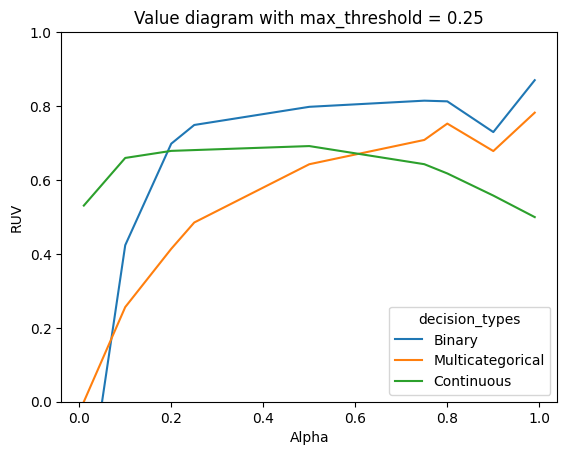

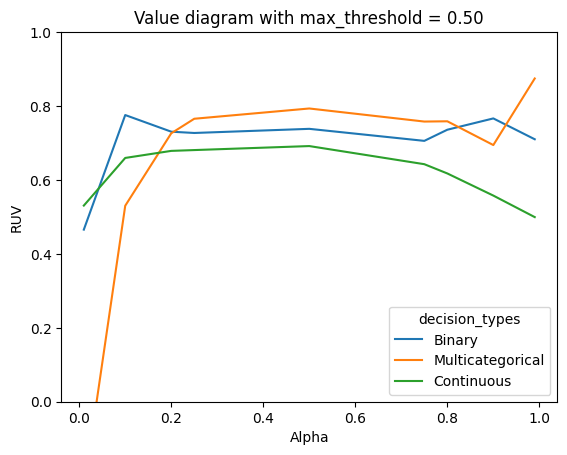

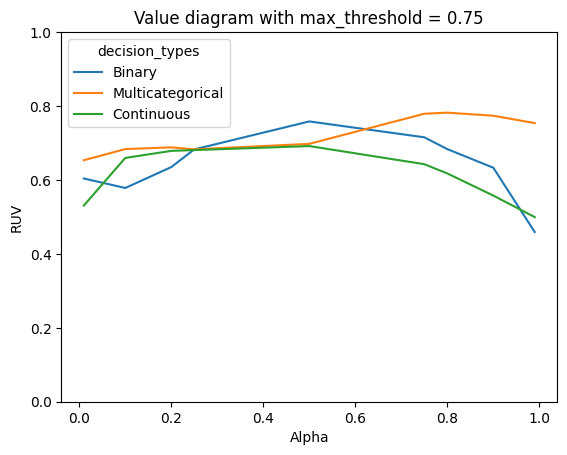

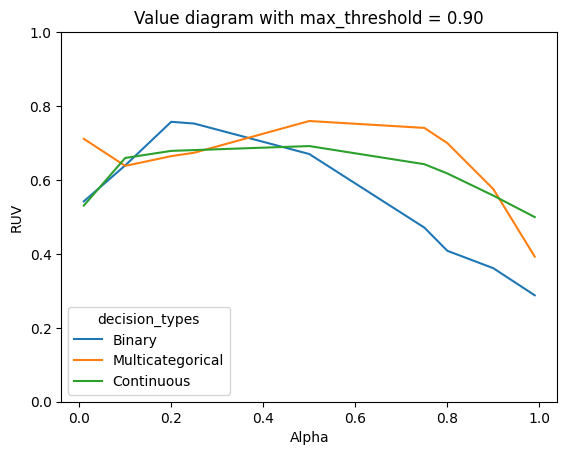

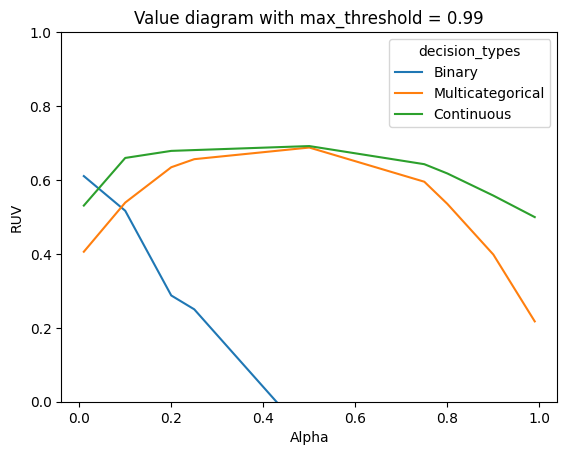

In [8]:
for max_threshold in max_thresholds:
    df = results.sel(max_thresholds=max_threshold).to_pandas()
    df.plot(ylim=(0,1), kind='line', title='Value diagram with max_threshold = %.2f' % max_threshold, xlabel='Alpha', ylabel='RUV')
    plt.show()

# Plot max difference in RUV (over all alpha)

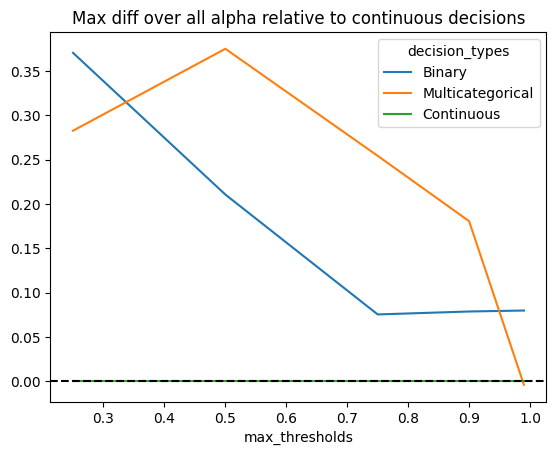

In [9]:
ref_ruv = results.sel(decision_types='Continuous')
difference = results - ref_ruv
max_difference = difference.max(axis=0).to_pandas()

max_difference.loc[['Binary', 'Multicategorical', 'Continuous']].T.plot(title='Max diff over all alpha relative to continuous decisions')
plt.axhline(0, color='black', linestyle='--')

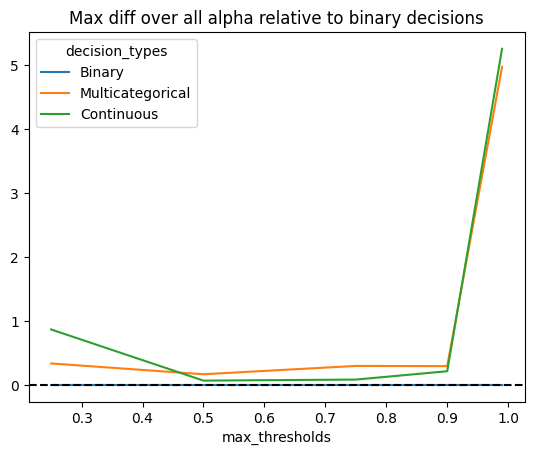

In [10]:
ref_ruv = results.sel(decision_types='Binary')
difference = results - ref_ruv
max_difference = difference.max(axis=0).to_pandas()

max_difference.loc[['Binary', 'Multicategorical', 'Continuous']].T.plot(title='Max diff over all alpha relative to binary decisions')
plt.axhline(0, color='black', linestyle='--')